In [1]:
import networkx as nx
# import osmnx as ox
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community.quality import performance
from cdlib import algorithms
from operator import itemgetter

import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from math import sqrt
import os

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'karateclub', 'wurlitzer', 'infomap', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


# 3-4 Interaction model

## Unconstrated model

In [2]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [3]:
london_OD=pd.read_csv("https://raw.githubusercontent.com/Jackeytanlor/urban_simulation_assessment/main/london_flows.csv")
london_OD_raw=london_OD.copy()


In [4]:
london_OD=london_OD.drop( index = london_OD.distance[london_OD.distance == 0].index )
london_OD=london_OD.drop( index = london_OD.jobs[london_OD.jobs== 0].index )
london_OD=london_OD.drop( index = london_OD.population[london_OD.population== 0].index )

In [5]:
cdatasub=london_OD.copy()

In [6]:
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    cdatasub[f"log_{x}"] = np.log(cdatasub[x])
    log_x_vars.append(f"log_{x}")

In [7]:
#create the formula
formula = 'flows ~ log_population + log_jobs + log_distance'

#run the regression
uncosim = smf.glm(formula = formula, 
                  data=cdatasub, 
                  family=sm.families.Poisson()).fit()
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61409
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2785e+06
Date:                Tue, 03 May 2022   Deviance:                   2.3848e+06
Time:                        05:15:52   Pearson chi2:                 4.76e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.7475      0.014   -273.

In [8]:
K = uncosim.params[0]
alpha = uncosim.params[1]
gamma = uncosim.params[2]
beta = -uncosim.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
cdatasub["unconstrainedEst2"] = np.exp(K 
                                       + alpha*cdatasub["log_population"] 
                                       + gamma*cdatasub["log_jobs"] 
                                       - beta*cdatasub["log_distance"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
cdatasub["fitted"] = predictions_summary_frame["mean"]
#round the numbers so that we don't get a half of a person
cdatasub["unconstrainedEst2"] = round(cdatasub["unconstrainedEst2"], 0)
#convert to integers
cdatasub["unconstrainedEst2"] = cdatasub["unconstrainedEst2"].astype(int)
#check that the sum of these estimates make sense
print(sum(cdatasub["unconstrainedEst2"]))
#turn it into a little matrix and have a look at your handy work
cdatasubmat2 = cdatasub.pivot_table(values ="unconstrainedEst2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

1542355


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,392
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,333
Acton Town,NaN,NaN,NaN,21.0,21.0,NaN,7.0,1.0,NaN,22.0,...,18.0,3.0,6.0,11.0,NaN,2.0,NaN,3.0,NaN,3862
Aldgate,NaN,NaN,7.0,NaN,81.0,NaN,NaN,1.0,NaN,47.0,...,14.0,NaN,8.0,6.0,NaN,3.0,NaN,3.0,NaN,6107
Aldgate East,NaN,NaN,7.0,85.0,NaN,NaN,3.0,1.0,NaN,48.0,...,14.0,3.0,8.0,7.0,NaN,3.0,NaN,3.0,NaN,6470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,26.0,28.0,NaN,NaN,NaN,NaN,25.0,...,14.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3707
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62
Woodside Park,NaN,NaN,5.0,18.0,18.0,NaN,2.0,NaN,NaN,21.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,2648


In [9]:
CalcRMSE(cdatasub["flows"], cdatasub["unconstrainedEst2"])

108.334

In [10]:
CalcRSquared(cdatasub["flows"], cdatasub["unconstrainedEst2"])

0.32119035773617927

## Single-constrated model in Scenario A

In [11]:
london_OD=pd.read_csv("https://raw.githubusercontent.com/Jackeytanlor/urban_simulation_assessment/main/london_flows.csv")
london_OD=london_OD.drop( index = london_OD.jobs[london_OD.jobs== 0].index )
london_OD=london_OD.drop( index = london_OD.distance[london_OD.distance == 0].index )

In [12]:
cdatasub=london_OD.copy()
x_variables = [ "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    cdatasub[f"log_{x}"] = np.log(cdatasub[x])
    log_x_vars.append(f"log_{x}")

In [13]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin +log_jobs + log_distance-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61436
Model:                            GLM   Df Residuals:                    61035
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Tue, 03 May 2022   Deviance:                   1.8615e+06
Time:                        05:16:34   Pearson chi2:                 2.78e+06
No. Iterations:                    26   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [14]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
cdatasub = cdatasub.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(cdatasub.groupby(["station_origin"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "station_origin", how = "left" )
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub.head()

,station_origin,station_destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,599,3.250242
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,599,3.250242
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,599,3.250242
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,599,3.250242
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,599,3.250242


In [15]:
alpha_i = prodSim.params[0:-2]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]
print(gamma)
print(beta)

0.7686156200124408
0.8781191183724275


In [16]:
cdatasub["prodsimest1"] = np.exp(cdatasub["alpha_i"]+gamma*cdatasub["log_jobs"] 
                                 - beta*cdatasub["log_distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
cdatasub.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,599,3.250242,55.010681
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,599,3.250242,0.986106
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,599,3.250242,2.755640
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,599,3.250242,66.457296
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,599,3.250242,49.060970
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096721,8.807842,599,599,3.250242,2.639418
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739337,8.249276,599,599,3.250242,3.275120
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,9.048280,599,599,3.250242,2.838948
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745236,8.784484,599,599,3.250242,2.056310
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415097,8.283576,599,599,3.250242,2.476929


In [17]:
#first round the estimates
cdatasub["prodsimest1"] = round(cdatasub["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
cdatasubmat3 = cdatasub.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [18]:
CalcRSquared(cdatasub["flows"], cdatasub["prodsimest1"])

0.3882847268291744

In [19]:
CalcRMSE(cdatasub["flows"], cdatasub["prodsimest1"])

102.873

In [20]:
store=cdatasub.copy()

### Decrease the number of jobs

In [21]:
def new_sal(row):
    if row["station_destination"] == "Canary Wharf":
        val = row["jobs"]*0.5
    else:
        val = row["jobs"]
    return val
        
cdatasub["jobs_b"] = cdatasub.apply(new_sal, axis =1)
cdatasub.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,jobs_b
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,599,599,3.250242,55.0,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,599,599,3.250242,1.0,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,599,599,3.250242,3.0,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,599,599,3.250242,66.0,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,599,599,3.250242,49.0,15428.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096721,8.807842,599,599,3.250242,3.0,1208.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739337,8.249276,599,599,3.250242,3.0,845.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,9.048280,599,599,3.250242,3.0,1748.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745236,8.784484,599,599,3.250242,2.0,850.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415097,8.283576,599,599,3.250242,2.0,611.0


In [22]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdatasub["jobs"]**gamma
dist_beta = cdatasub["distance"]**beta
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [23]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest3"] = cdatasub["A_i"]*cdatasub["O_i"]*Dj2_gamma*dist_beta
#round
cdatasub["prodsimest3"] = round(cdatasub["prodsimest3"])
#check
cdatasub[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,55.0,217.0
1,1.0,4.0
2,3.0,3.0
3,66.0,115.0
4,49.0,20.0
...,...,...
61431,121.0,189.0
61432,259.0,190.0
61433,32.0,27.0
61434,98.0,31.0


In [24]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = cdatasub["jobs_b"]**gamma
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [25]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest4"] = cdatasub["A_i2"]*cdatasub["O_i"]*Dj3_gamma*dist_beta
#round
cdatasub["prodsimest4"] = round(cdatasub["prodsimest4"])

In [26]:
cdatasubmat5 = cdatasub.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat5

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,27.0,28.0,NaN,2.0,4.0,NaN,26.0,...,22.0,3.0,13.0,3.0,NaN,7.0,NaN,7.0,NaN,3744.0
Aldgate,NaN,NaN,14.0,NaN,4.0,NaN,NaN,6.0,NaN,10.0,...,35.0,NaN,11.0,8.0,NaN,5.0,NaN,6.0,NaN,2886.0
Aldgate East,NaN,NaN,15.0,5.0,NaN,NaN,8.0,7.0,NaN,11.0,...,38.0,6.0,12.0,9.0,NaN,5.0,NaN,7.0,NaN,3182.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,18.0,26.0,24.0,NaN,NaN,NaN,NaN,30.0,...,43.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,528.0
Woodside Park,NaN,NaN,11.0,20.0,21.0,NaN,6.0,NaN,NaN,18.0,...,26.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [27]:
cdatasub["difference"]=cdatasub["prodsimest4"]-cdatasub["prodsimest1"]

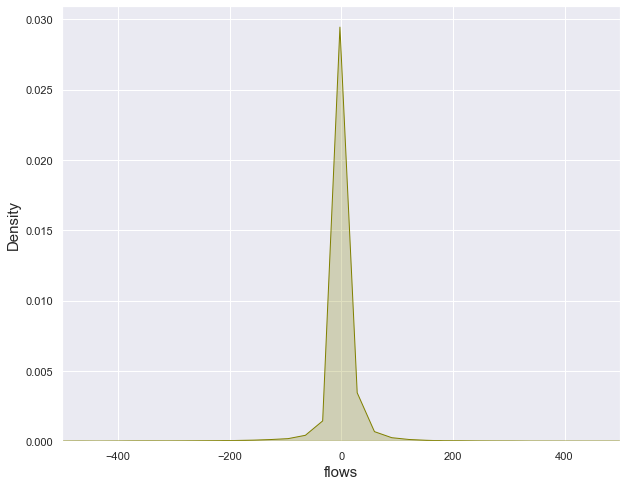

In [28]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
plt.figure(figsize=(10, 8))
# Narrower bandwidth
sns.kdeplot(cdatasub["difference"], shade=True, color='olive') # if using seaborn < 0.11.0
plt.xlim(-500, 500)
plt.xlabel('flows',size=15)
plt.ylabel('Density',size=15)
plt.show()

## Doubly constrated model in sceanrio B

In [29]:
london_OD=pd.read_csv("https://raw.githubusercontent.com/Jackeytanlor/urban_simulation_assessment/main/london_flows.csv")

In [30]:
# london_OD=london_raw.copy()

change distance to cost movement

In [31]:
london_OD['cost1']=london_OD['distance']/2

In [32]:
london_OD['cost2']=london_OD["distance"]/1.5

In [33]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

### First parameter

In [34]:
cdatasub=london_OD.copy()

In [35]:
x_variables = [ "distance"]
log_x_vars = []
for x in x_variables:
    cdatasub[f"log_{x}"] = np.log(cdatasub[x])
    log_x_vars.append(f"log_{x}")

In [36]:
# Run a doubly constrained SIM with a negative exponential cost function.
doubsim_form = 'flows ~ station_origin + station_destination + cost1-1'
doubsim1 = smf.glm(formula=doubsim_form, data = cdatasub, family = sm.families.Poisson()).fit()
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    60676
Model Family:                 Poisson   Df Model:                          797
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.6447e+05
Date:                Tue, 03 May 2022   Deviance:                   1.5567e+06
Time:                        05:19:08   Pearson chi2:                 2.05e+06
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [37]:
cdatasub["doubsimfitted1"] = np.round(doubsim1.mu,0)

In [38]:
CalcRSquared(cdatasub["flows"],cdatasub["doubsimfitted1"])

0.47663287125851117

#### Beta value

In [39]:
beta = -doubsim1.params[-1]
beta

0.00030369457507120487

In [40]:
O_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
cdatasub = cdatasub.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(cdatasub.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "station_destination", how = "left" )

In [41]:
cdatasub = balance_doubly_constrained(cdatasub,'station_origin','station_destination','O_i','D_j','distance',-beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_exp'] = np.round(cdatasub['O_i'] * cdatasub['Ai_exp'] * cdatasub['D_j'] * cdatasub['Bj_exp'] * 
                                   np.exp(cdatasub['distance']*-beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_exp',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,23,601.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1223.0
Acton Town,0,0,0,4,3,0,13,0,0,5,...,29,1,0,33,0,0,0,0,0,3739.0
Aldgate,0,0,0,0,49,0,0,0,0,27,...,1,0,1,1,0,0,0,0,0,2878.0
Aldgate East,0,0,0,61,0,0,0,0,0,28,...,1,0,1,1,0,0,0,0,0,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,39,53,0,0,0,0,19,...,1,0,2,0,0,0,0,0,0,4858.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,528.0
Woodside Park,0,0,0,11,9,0,0,0,0,25,...,2,0,1,0,0,0,0,0,0,3095.0


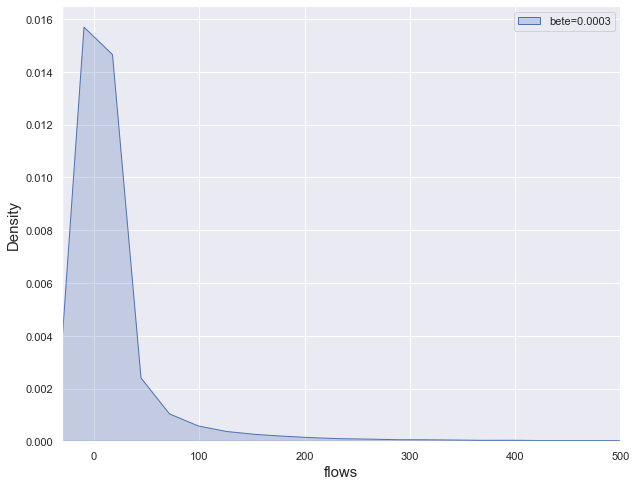

In [42]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 8))
# Narrower bandwidth
sns.kdeplot(cdatasub['SIM_est_exp'], shade=True, color='b',label=f"bete={round(beta,4)}") # if using seaborn < 0.11.0
plt.xlim(-200, 500)
plt.xlabel('flows',size=15)
plt.ylabel('Density',size=15)
plt.legend()
plt.show()

### Second parameter

In [43]:
cdatasub=london_OD.copy()

In [44]:
x_variables = [ "distance"]
log_x_vars = []
for x in x_variables:
    cdatasub[f"log_{x}"] = np.log(cdatasub[x])
    log_x_vars.append(f"log_{x}")

In [45]:
# Run a doubly constrained SIM with a negative exponential cost function.
doubsim_form = 'flows ~ station_origin + station_destination + cost2-1'
doubsim1 = smf.glm(formula=doubsim_form, data = cdatasub, family = sm.families.Poisson()).fit()
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    60676
Model Family:                 Poisson   Df Model:                          797
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.6447e+05
Date:                Tue, 03 May 2022   Deviance:                   1.5567e+06
Time:                        05:21:33   Pearson chi2:                 2.05e+06
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [46]:
cdatasub["doubsimfitted1"] = np.round(doubsim1.mu,0)

In [47]:
CalcRSquared(cdatasub["flows"],cdatasub["doubsimfitted1"])

0.47663287125851117

#### Beta value

In [48]:
beta = -doubsim1.params[-1]
beta

0.00022777093130367572

In [49]:
O_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
cdatasub = cdatasub.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(cdatasub.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "station_destination", how = "left" )

In [50]:
cdatasub = balance_doubly_constrained(cdatasub,'station_origin','station_destination','O_i','D_j','distance',-beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_exp'] = np.round(cdatasub['O_i'] * cdatasub['Ai_exp'] * cdatasub['D_j'] * cdatasub['Bj_exp'] * 
                                   np.exp(cdatasub['distance']*-beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_exp',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,27,599.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1226.0
Acton Town,0,0,0,7,6,0,18,0,0,8,...,39,3,1,26,0,0,0,0,0,3743.0
Aldgate,0,0,1,0,41,0,0,0,0,26,...,4,0,2,1,0,0,0,0,0,2873.0
Aldgate East,0,0,1,49,0,0,0,0,0,27,...,4,0,2,1,0,0,0,0,0,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,39,49,0,0,0,0,22,...,3,0,4,0,0,0,0,0,0,4863.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,531.0
Woodside Park,0,0,1,14,12,0,0,0,0,25,...,5,0,3,0,0,0,0,0,0,3087.0


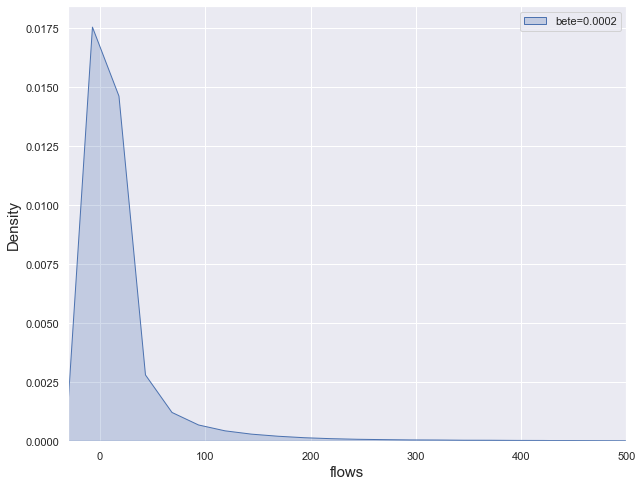

In [51]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 8))
# Narrower bandwidth
sns.kdeplot(cdatasub['SIM_est_exp'], shade=True, color='b',label=f"bete={round(beta,4)}") # if using seaborn < 0.11.0
plt.xlim(-200, 500)
plt.xlabel('flows',size=15)
plt.ylabel('Density',size=15)
plt.legend()
plt.show()